In [1]:
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


# In order to make the import of local modules
import sys
sys.path.append('.')

# local modules
from ultimate_tic_tac_toe_2 import *

In [2]:
# TODO - you need a more complex model to represent the interactions between the cells: more channels typically

# '''
class ValueFunction(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, stride=3, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, stride=1, bias=False),
        )

    def forward(self, board_matrix: torch.Tensor) -> torch.Tensor:
        xs = torch.FloatTensor(board_matrix)
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, 1, h, w))
        xs = self.fc(xs)
        xs = xs.reshape((batch_size,))
        return xs
# '''


'''
class ValueFunction(nn.Module):
    def __init__(self):
        super().__init__()
        # self.fc = nn.Sequential(nn.Linear(9*9, 50), nn.ReLU(), nn.Linear(50, 1))
        self.fc = nn.Linear(9*9, 1, bias=False)

    def forward(self, board_matrix: torch.Tensor) -> torch.Tensor:
        xs = torch.FloatTensor(board_matrix)
        if len(xs.shape) == 2:
            xs = xs.unsqueeze(dim=0)
        batch_size, h, w = xs.shape
        xs = xs.reshape((batch_size, h * w))
        xs = self.fc(xs)
        xs = xs.reshape((batch_size,))
        return xs
'''
    

policy = ValueFunction()
print(policy(np.ones(shape=(9, 9))))
print(policy(np.ones(shape=(5, 9, 9))))

tensor([-0.0425], grad_fn=<AsStridedBackward>)
tensor([-0.0425, -0.0425, -0.0425, -0.0425, -0.0425],
       grad_fn=<AsStridedBackward>)


In [ ]:
"""
Trying to learn a matrix of weight in order to score a board
"""

def train(policy: nn.Module, adversary_agent,
          episodes: int, discount_rate: float,
          start_epsilon: float, min_epsilon: float, epsilon_decay: float,
          learning_rate: float, learning_rate_decay: float,
          weight_decay: float
         ):
    
    # TODO - the parameters explode in size, the targets too... we need a way to keep them in check
    # => weight_decay?
    # => minibatches of random inputs?
    # => eligibility traces?
    # => monte carlo inside of TD(0)?
    
    '''
    for param in policy.parameters():
        param.data = torch.ones(size=param.data.size())
    '''
    
    rewards = []
    losses = []
    targets = []
    epsilon = start_epsilon

    criterion = nn.MSELoss()
    optimizer = optim.SGD(policy.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_decay)

    for episode in trange(episodes):
        episode_loss = 0.
        episode_reward = 0.

        board = Board.empty()
        player_id = random.choice([PLAYER, OPPONENT])

        while not board.is_game_over():
            # Play the opponent turn
            if player_id == OPPONENT:
                move = adversary_agent.get_action(board)
                board = board.play(OPPONENT, move)
                player_id = next_player(player_id)
                continue

            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                move = random.choice(board.available_moves)
                next_board = board.play(player_id, move)
            else:
                # policy.eval()
                boards = [board.play(player_id, move) for move in board.available_moves]
                # TODO - why does it fail when I stack the matrices?
                # '''
                ms = np.stack([b.as_board_matrix() for b in boards])
                vs = policy(ms)
                v, i = torch.max(vs, -1)
                next_board = boards[i.item()]
                # '''
                '''
                boards.sort(key=lambda b: policy(b.as_board_matrix()).item(), reverse=True if player_id == PLAYER else False)
                next_board = boards[0]
                '''
            
            # Receive next state and reward
            if next_board.winner == PLAYER:
                reward = 1.
                epsilon = max(min_epsilon, epsilon * epsilon_decay)
                scheduler.step()
            elif next_board.winner == OPPONENT:
                reward = -1.
            else:
                reward = 0.

            # Find V for t and t+1 state
            # policy.train()
            V = policy(board.as_board_matrix())
            if next_board.is_game_over():
                V_target = torch.FloatTensor([reward])
            else:
                next_value = policy(next_board.as_board_matrix())
                next_value = next_value.clone()
                next_value.detach_()
                V_target = reward + discount_rate * next_value
            targets.append(V_target.item())
            # V_target = policy(next_board.as_board_matrix()) + reward

            # Calculate loss & Update policy
            policy.zero_grad()
            loss = criterion(V, V_target)
            loss.backward()
            optimizer.step()

            # Record history
            episode_reward += reward
            episode_loss += loss.item()

            # Step forward
            board = next_board
            player_id = next_player(player_id)

        # print(board)
        rewards.append(episode_reward)
        losses.append(episode_loss)

    # Reporting
    fig, ax = plt.subplots(figsize=(15, 10), nrows=3)
    ax[0].plot(rewards, label="rewards")
    ax[0].plot(pd.Series(rewards).rolling(10).mean(), label="mean rewards")
    ax[1].plot(pd.Series(losses).rolling(10).sum() / 100., label="losses")
    ax[2].plot(targets, label="targets")
    for p in ax:
        p.legend()
    plt.show()

    
torch.manual_seed(1);
np.random.seed(1)

policy = ValueFunction()
train(policy=policy,
      adversary_agent=FirstMoveAgent(),
      episodes=1000, discount_rate=0.99,
      start_epsilon=0.5, min_epsilon=0.0, epsilon_decay=0.95,
      learning_rate=1e-2, learning_rate_decay=1.0,
      weight_decay=0.)

 92%|█████████▏| 920/1000 [01:32<00:08,  9.81it/s]

In [13]:
print(policy)
for param in policy.parameters():
    print(param.data)

ValueFunction(
  (fc): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(3, 3), bias=False)
    (1): ReLU()
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
)
tensor([[[[ 2.6482, -0.0168,  1.4826],
          [-1.5729,  1.3098, -2.1163],
          [ 1.4350, -0.9814, -1.5278]]]])
tensor([[[[-1.7313, -2.5407, -2.0681],
          [-1.4369, -1.0284, -0.0620],
          [-2.0336, -2.4209, -2.0422]]]])


100%|██████████| 1000/1000 [01:10<00:00, 13.48it/s]


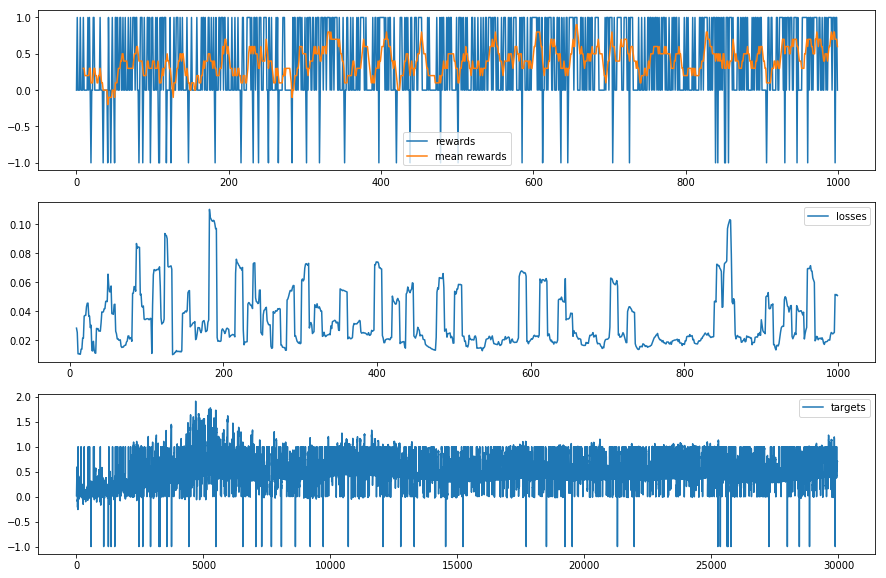

In [16]:
# adversary_agent = MinimaxAgent(player=OPPONENT, max_depth=2, eval_fct=CountOwnedEvaluation())
policy = ValueFunction()
train(policy=policy,
      adversary_agent=RandomAgent(),
      episodes=1000, discount_rate=0.99,
      start_epsilon=0.5, min_epsilon=0.0, epsilon_decay=0.95,
      learning_rate=1e-2, learning_rate_decay=1.0,
      weight_decay=0.)

In [17]:
print(policy)
for param in policy.parameters():
    print(param.data)

ValueFunction(
  (fc): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(3, 3), bias=False)
    (1): ReLU()
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
)
tensor([[[[ 0.7030, -0.0483, -0.0835],
          [ 0.0331, -0.1302, -0.0591],
          [ 0.0145, -0.2166, -0.1814]]]])
tensor([[[[ 0.5399, -0.1392, -0.0414],
          [-0.0625,  0.2188, -0.1004],
          [-0.1859,  0.2437, -0.0901]]]])
